In [4]:
!pip install -U nltk fasttext scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 56.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.


In [ ]:
!wget -c -P ../models https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip ../models/cc.en.300.bin.gz

--2025-08-24 09:58:58--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.81, 18.164.78.121, 18.164.78.128, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G   264MB/s    in 14s     

2025-08-24 09:59:12 (308 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [ ]:
import fasttext
en_model = fasttext.load_model('../models/cc.en.300.bin')

In [7]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_embedding_association(target, attributes_A, attributes_B, ft_model):
    target_embedding = ft_model.get_word_vector(target).reshape(1, -1)
    a_embeddings = np.array([ft_model.get_word_vector(word) for word in attributes_A])
    b_embeddings = np.array([ft_model.get_word_vector(word) for word in attributes_B])

    similarity_a = cosine_similarity(target_embedding, a_embeddings).mean()
    similarity_b = cosine_similarity(target_embedding, b_embeddings).mean()

    return similarity_a - similarity_b

def get_weat_metric(target_X, target_Y, attributes_A, attributes_B, ft_model):
    return sum(get_embedding_association(x, attributes_A, attributes_B, ft_model) for x in target_X) - sum(get_embedding_association(y, attributes_A, attributes_B, ft_model) for y in Y)

def get_effect_size(target_X, target_Y, attributes_A, attributes_B, ft_model):
    s_X = [get_embedding_association(x, attributes_A, attributes_B, ft_model) for x in target_X]
    s_Y = [get_embedding_association(y, attributes_A, attributes_B, ft_model) for y in target_Y]
    return (np.mean(s_X) - np.mean(s_Y)) / np.std(s_X + s_Y)

In [27]:
import matplotlib.pyplot as plt

def get_bias_evaluation(test_set, attributes_A, attributes_B, ft_model):
    effect_sizes = []
    labels = []
    for X, Y, label in target_sets:
        es = get_effect_size(X, Y, attributes_A, attributes_B, ft_model)
        effect_sizes.append(es)
        # labels.append(label+f"\n{attributes_A}\n{attributes_B}")
        labels.append(label)
        
    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, effect_sizes, color="skyblue", edgecolor="black")
    plt.axhline(0, color="black", linewidth=0.8)
    plt.ylabel("Effect Size")
    plt.title("WEAT Effect Sizes across Target Sets")
    
    for bar, val in zip(bars, effect_sizes):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{val:.2f}", 
                 ha='center', va='bottom')
    plt.show()

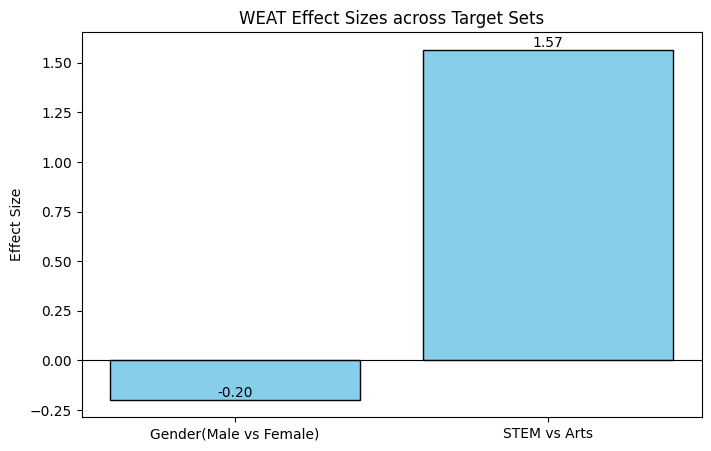

In [28]:
target_sets = [
    (["man", "male", "boy"], ["woman", "female", "girl"], "Gender(Male vs Female)"),
    (["math", "physics", "engineering"], ["art", "literature", "dance"], "STEM vs Arts")
]

attributes_A = ["career", "office", "job", "success"]
attributes_B = ["home", "family", "children", "passive"]
get_bias_evaluation(target_sets, attributes_A, attributes_B, en_model)

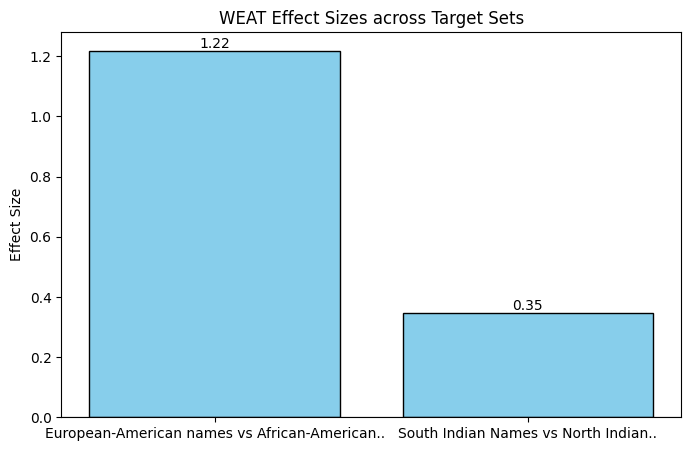

In [34]:
target_sets = [
    (
        ["Brad", "Greg", "Emily", "Anne", "Meredith", "Todd", "Kristin", "Allison", "Jill", "Matthew", "Amanda", "Courtney", "Brett", "Neil", "Amy", "Jay"],
        ["Jamal", "Tyrone", "Ebony", "Latoya", "Malik", "Terrell", "Shaniqua", "Tanisha", "Jermaine", "Darnell", "Hakim", "Tremayne", "Aisha", "Shanice", "DeAndre", "Lakisha"],
        "European-American names vs African-American.."
    ),
    (
        ["Harish", "Anand", "Karthik", "Raghav", "Pradeep", "Suresh", "Arvind", "Balaji", "Vignesh", "Krishna", "Rajesh", "Hari", "Murali", "Senthil"],
        ["Amit", "Raj", "Vikas", "Pankaj", "Sunil", "Rohit", "Sanjay", "Deepak", "Anil", "Vivek", "Manish", "Alok", "Ashish", "Rajat"],
        "South Indian Names vs North Indian.."
    )
]

attributes_A = ["love", "peace", "honor", "friend", "happy", "joy", "pleasure", "wonderful", "glorious", "loyal"]
attributes_B = ["evil", "failure", "hurt", "nasty", "ugly", "agony", "terrible", "horrible", "war", "abuse"]

get_bias_evaluation(target_sets, attributes_A, attributes_B, en_model)